In [1]:
# imports

# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

#### UNet3+  3 channels

In [4]:
# Unet3+
from src.unet3plus import UNet_3Plus

In [5]:
# Update the notebook to incorporate any changes made in the environment
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from src.load_XY import load_XY_3chanel

# Dataset import:
data_folder = "./data"

X, y = load_XY_3chanel(data_folder)

In [7]:
import random
import numpy as np

# Combine X and y into a list of tuples
data = list(zip(X, y))

# Assuming each patient has 80 lists of tensors
lists_per_patient = 80

# Total number of patients
total_patients = len(data) // lists_per_patient

# Set the seed for reproducibility
random.seed(42)

# Shuffle the indices of patients
shuffled_patients = list(range(total_patients))
random.shuffle(shuffled_patients)

# Calculate the number of patients for each split
train_patients = 58
val_patients = 16
test_patients = 8

# Extract data for each split based on the shuffled indices
train_indices = shuffled_patients[:train_patients]
val_indices = shuffled_patients[train_patients: train_patients + val_patients]
test_indices = shuffled_patients[train_patients + val_patients: train_patients + val_patients + test_patients]

# Extract data for each split
train_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in train_indices]
val_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in val_indices]
test_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in test_indices]

# Flatten the lists of lists into a single list for X and y
X_train, y_train = zip(*[item for sublist in train_data for item in sublist])
X_val, y_val = zip(*[item for sublist in val_data for item in sublist])
X_test, y_test = zip(*[item for sublist in test_data for item in sublist])

# Convert train, test and val into numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [9]:
# lenghts of train, test and val
print(f"Dimension of training set: {len(X_train), len(y_train)}\n")
print(f"Dimension of test set: {len(X_test), len(y_test)}\n")
print(f"Dimension of validation set: {len(X_val), len(y_val)}")

Dimension of training set: (4640, 4640)

Dimension of test set: (640, 640)

Dimension of validation set: (1280, 1280)


In [10]:
import torch

# Convert numpy array to tensors
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_val = torch.from_numpy(X_val).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)


# Match y dimension to the X
# y_train is a NumPy array
y_train = y_train[:, np.newaxis, :, :]
# Now, y_train has shape (4640, 1, 64, 64)

y_val = y_val[:, np.newaxis, :, :]
y_test = y_test[:, np.newaxis, :, :]

In [11]:
y_train.shape

(4640, 1, 64, 64)

In [12]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Creation of dataloaders
train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size=64, shuffle=True)
validation_dataloader = DataLoader(CustomDataset(X_val, y_val), batch_size=64, shuffle=True)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size=64, shuffle=True)

In [25]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net3plus = UNet_3Plus().to(device)

print(net3plus)

UNet_3Plus(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

##### Training

In [18]:
from torch import nn

model_save_path = "./model/unet3+_3c_MAE_200ep.pth"
loss_fn = nn.L1Loss()
epochs = 200
learning_rate = 1e-4
optimizer = torch.optim.Adam(net3plus.parameters(), lr=learning_rate)

Epoch 1/200, loss: 0.4650
Validation loss: 0.0103

Epoch 2/200, loss: 0.0105
Validation loss: 0.0071

Epoch 3/200, loss: 0.0064
Validation loss: 0.0058

Epoch 4/200, loss: 0.0056
Validation loss: 0.0055

Epoch 5/200, loss: 0.0051
Validation loss: 0.0052

Epoch 6/200, loss: 0.0048
Validation loss: 0.0050

Epoch 7/200, loss: 0.0049
Validation loss: 0.0049

Epoch 8/200, loss: 0.0047
Validation loss: 0.0049

Epoch 9/200, loss: 0.0048
Validation loss: 0.0048

Epoch 10/200, loss: 0.0043
Validation loss: 0.0047

Epoch 11/200, loss: 0.0042
Validation loss: 0.0048

Epoch 12/200, loss: 0.0043
Validation loss: 0.0049

Epoch 13/200, loss: 0.0048
Validation loss: 0.0045

Epoch 14/200, loss: 0.0039
Validation loss: 0.0045

Epoch 15/200, loss: 0.0038
Validation loss: 0.0049

Epoch 16/200, loss: 0.0040
Validation loss: 0.0043

Epoch 17/200, loss: 0.0039
Validation loss: 0.0043

Epoch 18/200, loss: 0.0037
Validation loss: 0.0045

Epoch 19/200, loss: 0.0035
Validation loss: 0.0044

Epoch 20/200, loss: 0

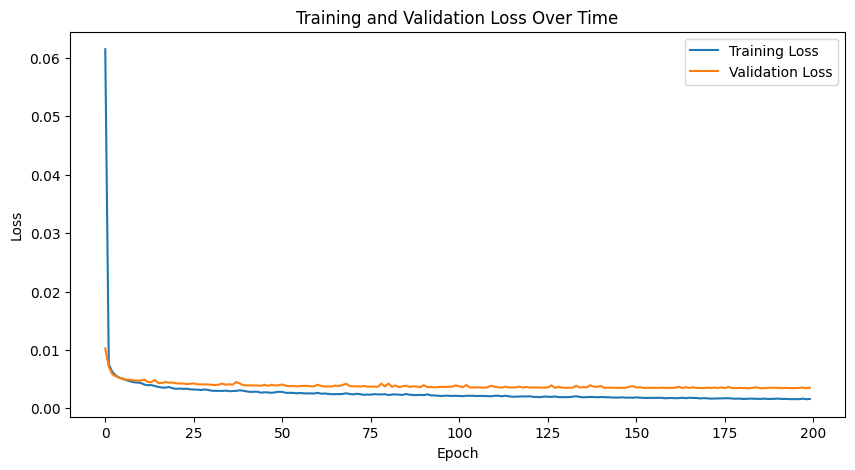




Test set: 
 Avg PSNR: 40.9 dB, Avg loss: 0.003230
  Min PSNR: 40.6 dB, Max PSNR: 41.2 dB



In [19]:
torch.manual_seed(42)
eval(net3plus, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [23]:
from torch import nn

model_save_path = "./model/unet3+_3c_MAE_150ep_lr3.pth"
loss_fn = nn.L1Loss()
epochs = 150
learning_rate = 1e-3
optimizer = torch.optim.Adam(net3plus.parameters(), lr=learning_rate)

Epoch 1/150, loss: 0.3936
Validation loss: 0.0073

Epoch 2/150, loss: 0.0070
Validation loss: 0.0071

Epoch 3/150, loss: 0.0051
Validation loss: 0.0056

Epoch 4/150, loss: 0.0045
Validation loss: 0.0064

Epoch 5/150, loss: 0.0040
Validation loss: 0.0047

Epoch 6/150, loss: 0.0039
Validation loss: 0.0053

Epoch 7/150, loss: 0.0044
Validation loss: 0.0040

Epoch 8/150, loss: 0.0039
Validation loss: 0.0041

Epoch 9/150, loss: 0.0042
Validation loss: 0.0042

Epoch 10/150, loss: 0.0038
Validation loss: 0.0038

Epoch 11/150, loss: 0.0037
Validation loss: 0.0053

Epoch 12/150, loss: 0.0039
Validation loss: 0.0059

Epoch 13/150, loss: 0.0052
Validation loss: 0.0048

Epoch 14/150, loss: 0.0037
Validation loss: 0.0046

Epoch 15/150, loss: 0.0034
Validation loss: 0.0066

Epoch 16/150, loss: 0.0036
Validation loss: 0.0041

Epoch 17/150, loss: 0.0035
Validation loss: 0.0036

Epoch 18/150, loss: 0.0034
Validation loss: 0.0041

Epoch 19/150, loss: 0.0034
Validation loss: 0.0045

Epoch 20/150, loss: 0

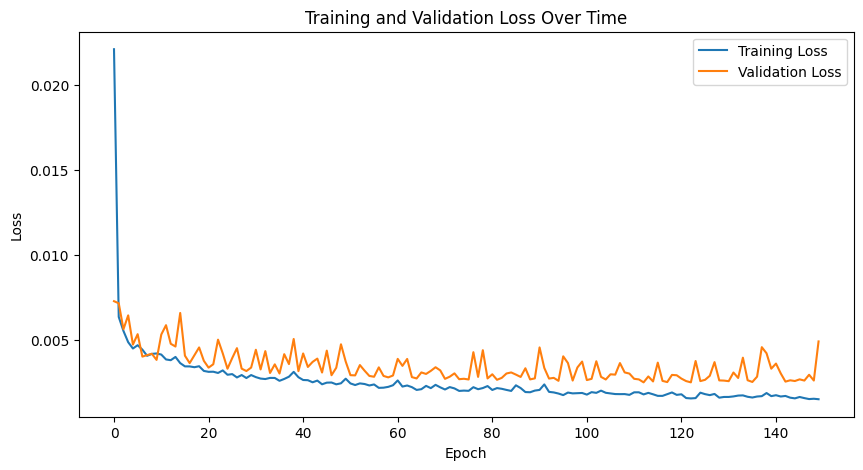




Test set: 
 Avg PSNR: 39.5 dB, Avg loss: 0.004826
  Min PSNR: 38.4 dB, Max PSNR: 40.7 dB



In [24]:
torch.manual_seed(42)
eval(net3plus, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

In [26]:
from torch import nn

model_save_path = "./model/unet3+_3c_MSE_100ep_lr6.pth"
loss_fn = nn.MSELoss()
epochs = 100
learning_rate = 1e-6
optimizer = torch.optim.Adam(net3plus.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.1906
Validation loss: 0.1363

Epoch 2/100, loss: 0.1375
Validation loss: 0.1033

Epoch 3/100, loss: 0.1041
Validation loss: 0.0772

Epoch 4/100, loss: 0.0764
Validation loss: 0.0587

Epoch 5/100, loss: 0.0584
Validation loss: 0.0454

Epoch 6/100, loss: 0.0442
Validation loss: 0.0355

Epoch 7/100, loss: 0.0349
Validation loss: 0.0289

Epoch 8/100, loss: 0.0312
Validation loss: 0.0231

Epoch 9/100, loss: 0.0235
Validation loss: 0.0191

Epoch 10/100, loss: 0.0187
Validation loss: 0.0164

Epoch 11/100, loss: 0.0153
Validation loss: 0.0138

Epoch 12/100, loss: 0.0136
Validation loss: 0.0122

Epoch 13/100, loss: 0.0130
Validation loss: 0.0105

Epoch 14/100, loss: 0.0100
Validation loss: 0.0093

Epoch 15/100, loss: 0.0091
Validation loss: 0.0083

Epoch 16/100, loss: 0.0079
Validation loss: 0.0074

Epoch 17/100, loss: 0.0066
Validation loss: 0.0066

Epoch 18/100, loss: 0.0067
Validation loss: 0.0061

Epoch 19/100, loss: 0.0063
Validation loss: 0.0055

Epoch 20/100, loss: 0

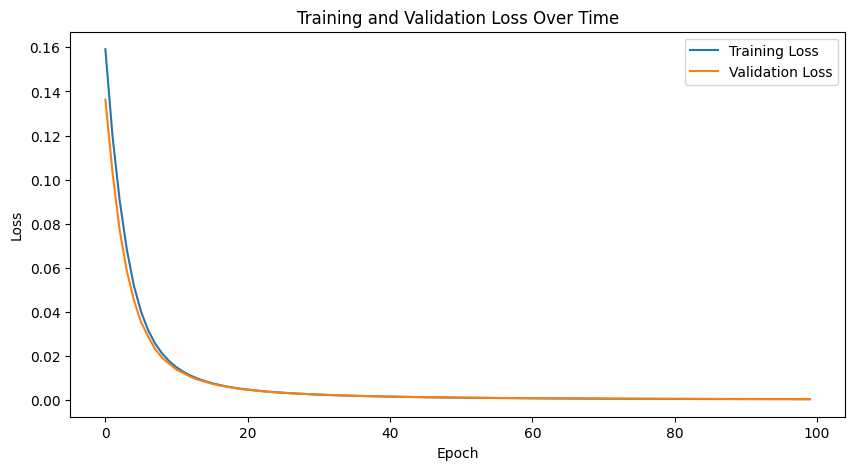




Test set: 
 Avg PSNR: 33.8 dB, Avg loss: 0.000418
  Min PSNR: 33.6 dB, Max PSNR: 34.1 dB



In [27]:
torch.manual_seed(42)
eval(net3plus, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

##### Prediction

In [ ]:
from src.predict import predict3
from src.visualization import visualize_prediction
import torch

device = ('cuda' if torch.cuda.is_available() else 'cpu')

# load the images for visualization
low = "./test/low_edep.mhd"
ct = "./test/ct.mhd"
ground_truth_data = "./test/high_edep.mhd"
annotated = "./test/annotated_ct.npy"

# define paths for loading the features and saving the output visualization
paths = "./test/"
save_path = "./images/unet3+_3c_MAE_200ep.png"


# define path for model trained
model_path = './model/unet3+_3c_MAE_200ep.pth'


# load the model
model = torch.load(model_path)

# make prediction
predicted_data = predict3(model, paths, device=device)

# Visualisation
visualize_prediction(low, ground_truth_data, predicted_data, save_path, ct, annotated)